In [1]:
import ROOT
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.22/08


In [61]:
sig_df = pd.read_pickle('Pkl_ips/SC_SUSY_235_mchi_60.pkl')
tt_df  = pd.read_pickle('Pkl_ips/SC_ttbar.pkl')
vv_df  = pd.read_pickle('Pkl_ips/SC_VV.pkl')
st_df  = pd.read_pickle('Pkl_ips/SC_ST.pkl')
sat_df = pd.read_pickle('Pkl_ips/SC_SAT.pkl')

<ipython-input-40-840ea675a416>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,8))


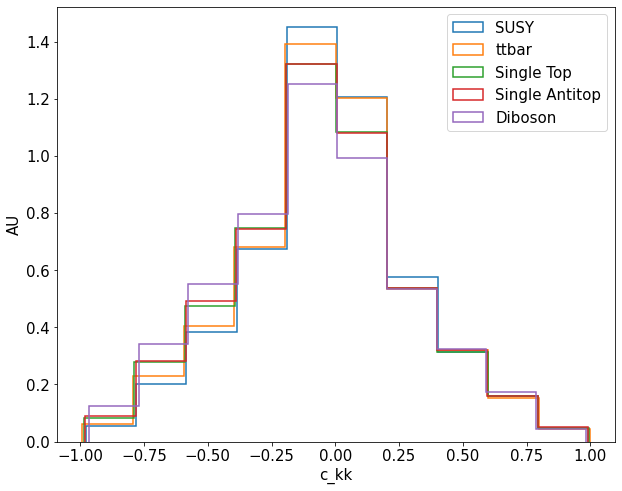

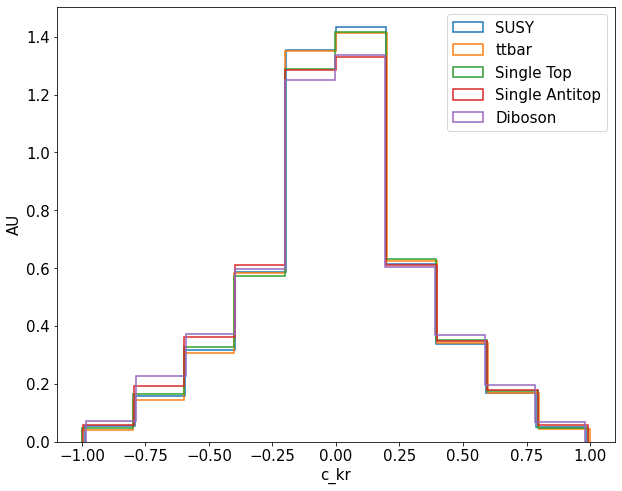

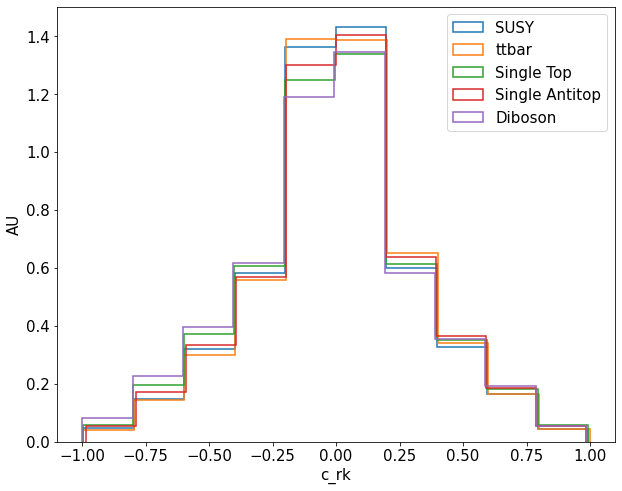

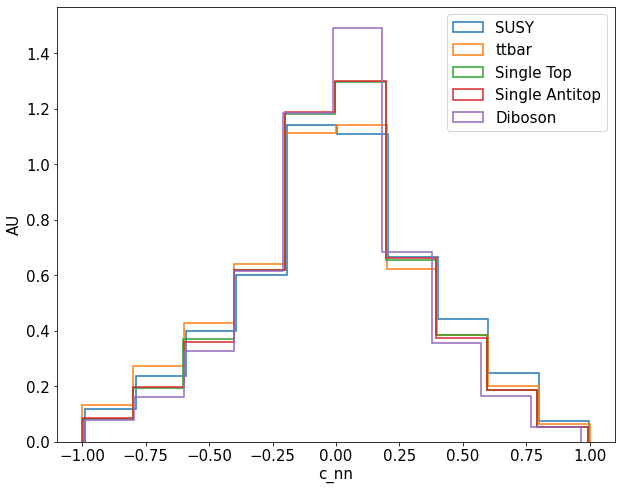

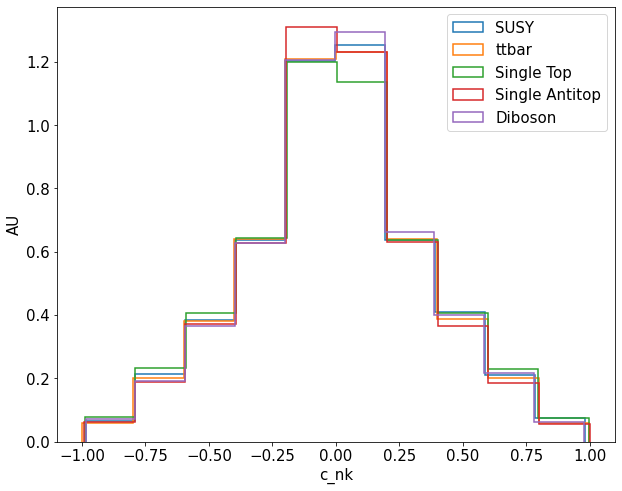

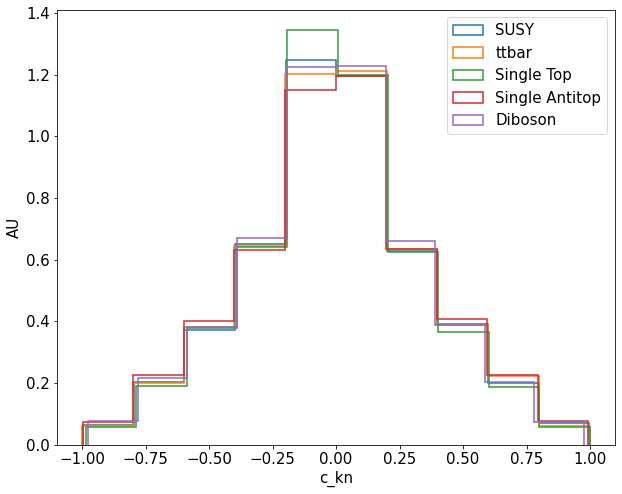

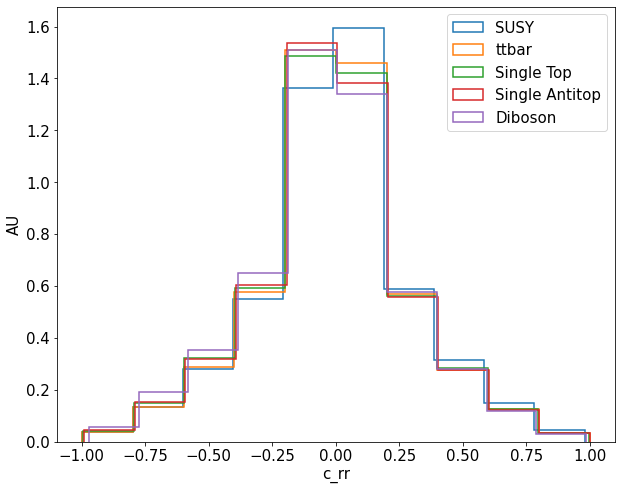

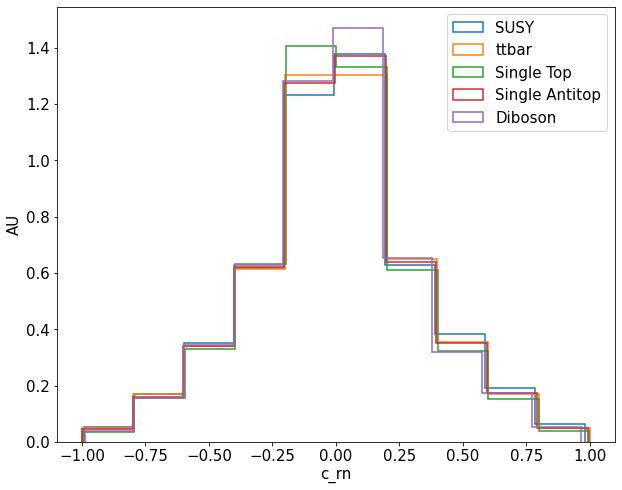

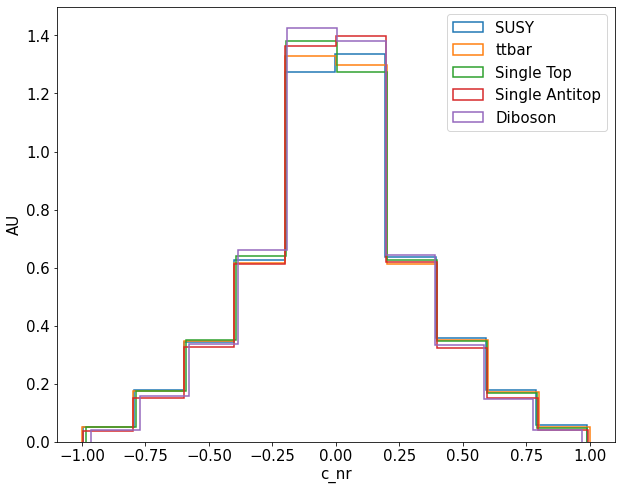

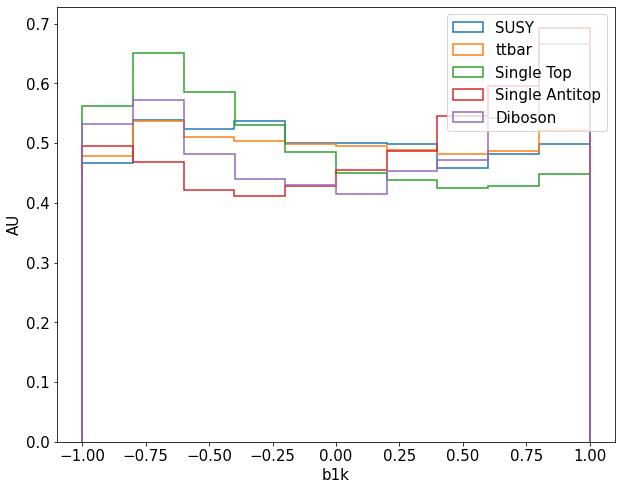

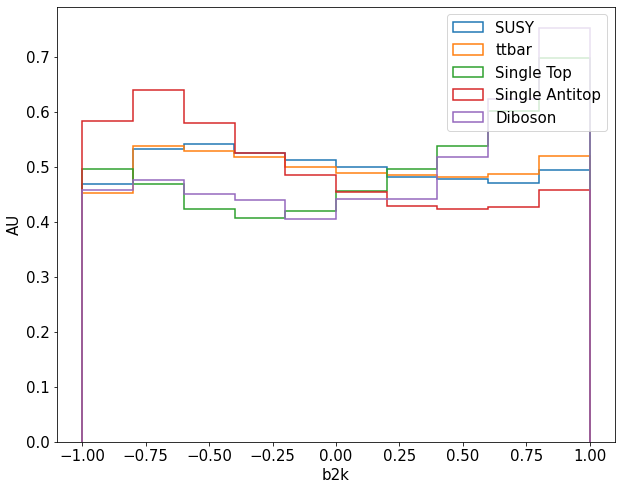

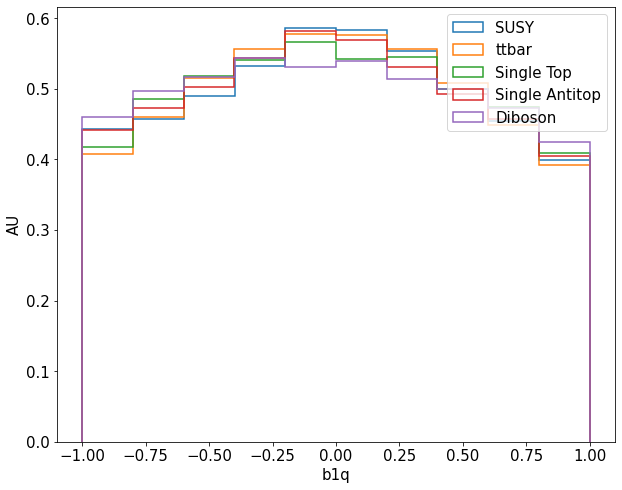

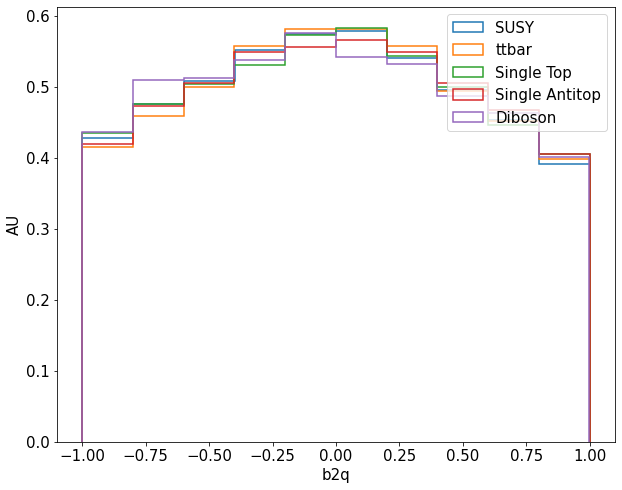

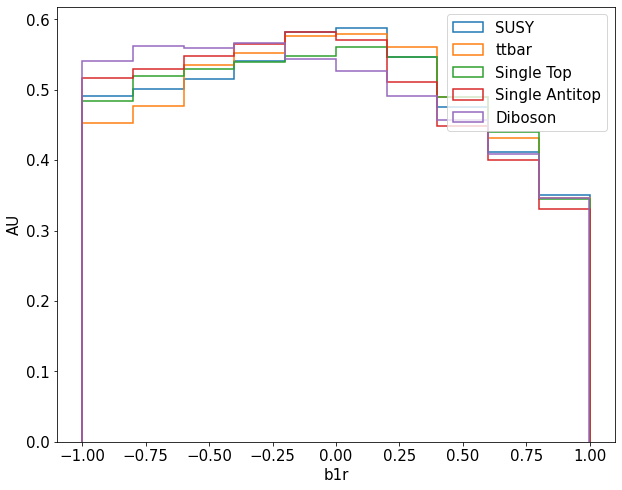

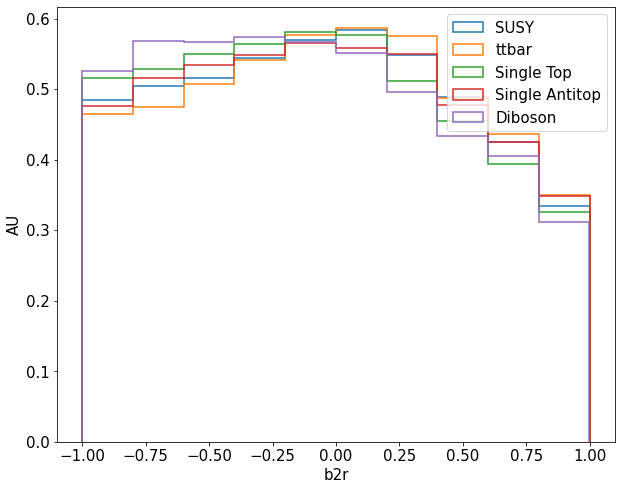

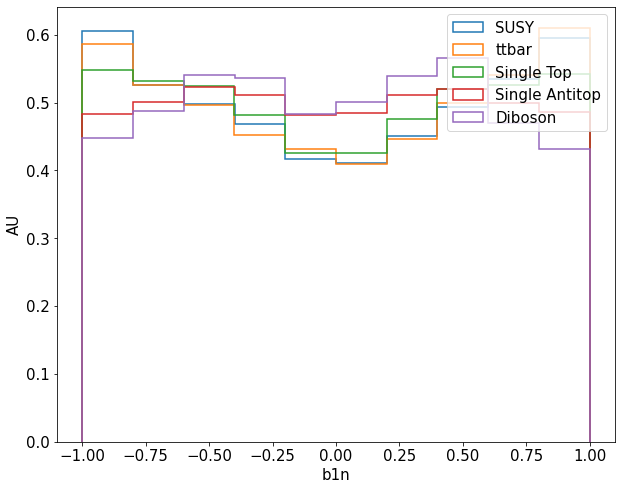

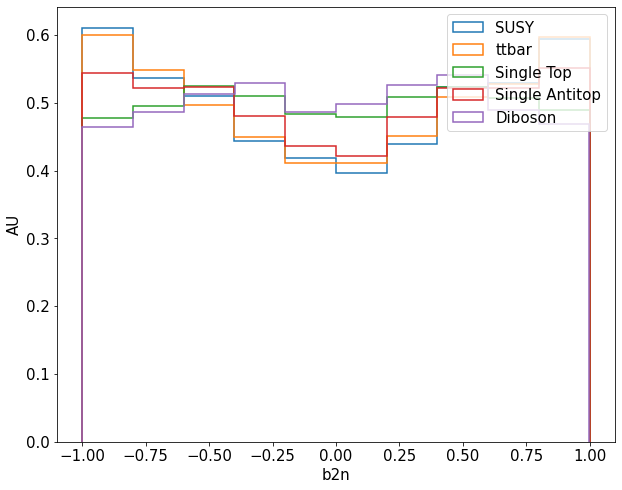

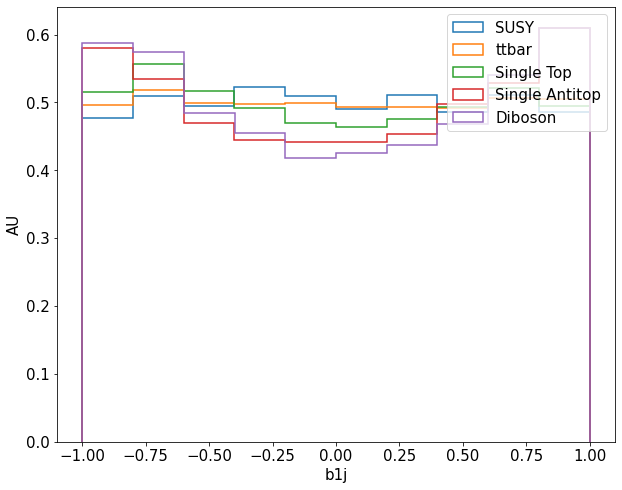

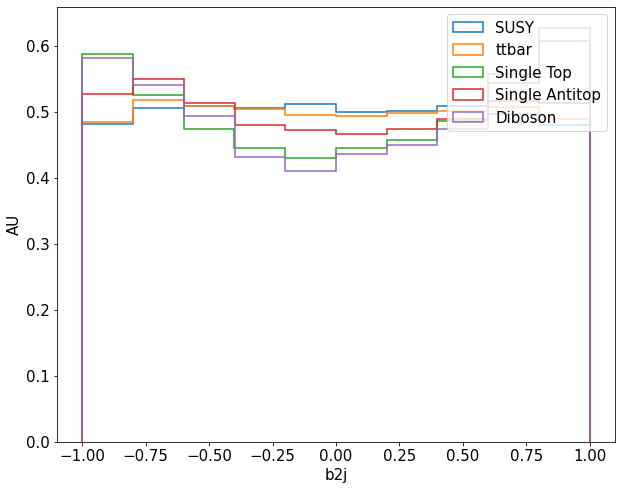

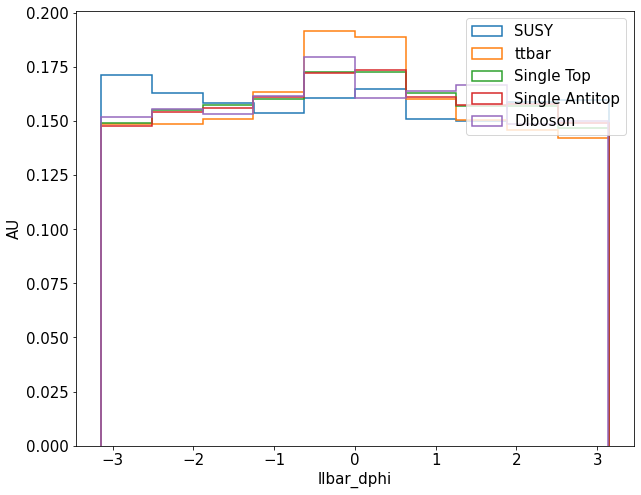

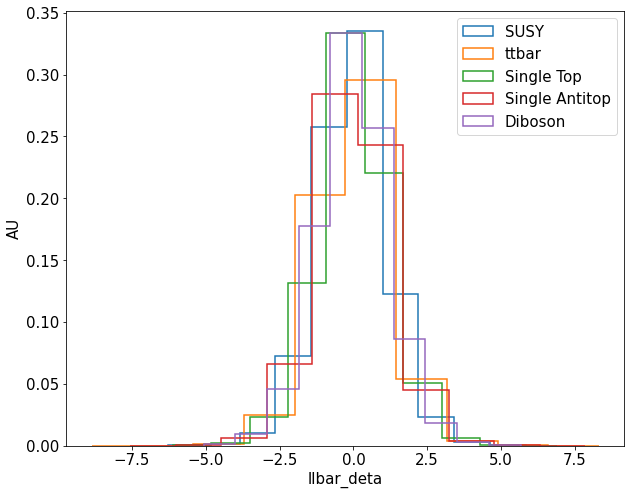

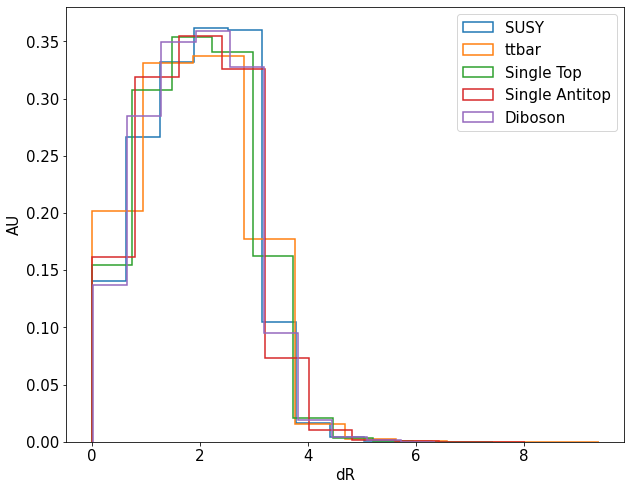

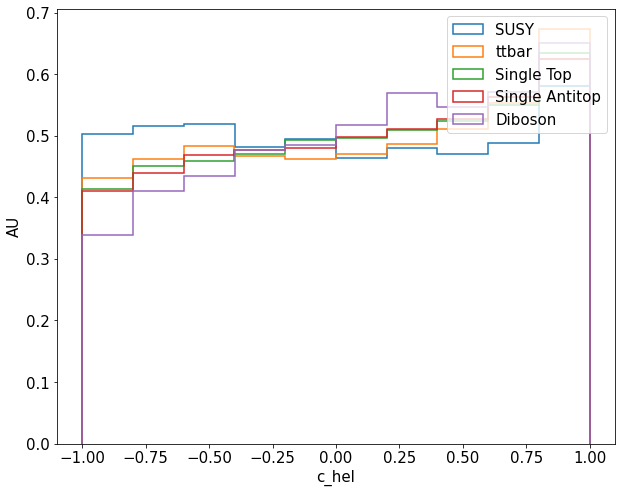

In [40]:
x_labels = sig_df.columns
count    = 0

for i in sig_df.columns :
    plt.figure(figsize=(10,8))
    # Plot the histograms
    plt.hist(sig_df[i], histtype='step', density=True, linewidth=1.5, label='SUSY')
    plt.hist(tt_df[i] , histtype='step', density=True, linewidth=1.5, label='ttbar')
    plt.hist(st_df[i] , histtype='step', density=True, linewidth=1.5, label='Single Top')
    plt.hist(sat_df[i], histtype='step', density=True, linewidth=1.5, label='Single Antitop')
    plt.hist(vv_df[i] , histtype='step', density=True, linewidth=1.5, label='Diboson')
    
    # Formatting
    plt.xlabel(x_labels[count], fontsize=15)
    plt.ylabel('AU', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(fontsize=15)

    img_name = 'Images/Mstop_235_' + str(x_labels[count]) + '.jpg' 
    count   += 1
    plt.savefig(img_name)

In [62]:
# Standardize
sig_mean = sig_df.mean()
sig_std  = sig_df.std()

tt_mean = tt_df.mean()
tt_std  = tt_df.std()

st_mean = st_df.mean()
st_std  = st_df.std()

vv_mean = vv_df.mean()
vv_std  = vv_df.std()

sat_mean = sat_df.mean()
sat_std  = sat_df.std()

sig_df = (sig_df - sig_mean)/ sig_std
tt_df  = (tt_df  - tt_mean)/ tt_std
st_df  = (st_df  - st_mean)/ st_std
vv_df  = (vv_df  - vv_mean)/ vv_std
sat_df = (sat_df  - sat_mean)/ sat_std

In [63]:
# Set both to equal sizes 
# Reducing the bkg dataframe size

sig_df_train = sig_df[1:17000]
tt_df_train  = tt_df[1:35000]
st_df_train  = st_df[1:10000]
sat_df_train = sat_df[1:10000]
vv_df_train  = vv_df[1:2000]

In [64]:
bkgList = [tt_df_train, st_df_train, sat_df_train, vv_df_train]  # List of your dataframes

bkg_df_train = pd.concat(bkgList)

signal = sig_df_train.values
bkg    = bkg_df_train.values

sig_label = np.ones(len(signal))
bkg_label = np.zeros(len(bkg))

data      = np.concatenate((signal,bkg))
label     = np.concatenate((sig_label,bkg_label))

In [65]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=2, shuffle=True)
skf.get_n_splits(data, label)
skf.split(data, label)

<generator object _BaseKFold.split at 0x7fb528a6dc10>

In [66]:
for train_index, test_index in skf.split(data, label):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = data[train_index], data[test_index]
    y_train, y_test = label[train_index], label[test_index]

TRAIN: [    1     4    11 ... 73985 73987 73991] TEST: [    0     2     3 ... 73992 73993 73994]
TRAIN: [    0     2     3 ... 73992 73993 73994] TEST: [    1     4    11 ... 73985 73987 73991]


In [67]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

In [68]:
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
from skopt import gp_minimize

model = Sequential()
model.add(Dense(200, input_dim = 23  ,activation='relu'))
model.add(Dropout(0.1))
#model.add(Dense(100, input_dim = 100 ,activation='tanh'))
#model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 200)               4800      
_________________________________________________________________
dropout_8 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 201       
Total params: 5,001
Trainable params: 5,001
Non-trainable params: 0
_________________________________________________________________


In [69]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [70]:
hist = model.fit(x_train, y_train, batch_size=100, epochs=1000,verbose=1, shuffle=True, validation_split=0.2,
                  callbacks=[EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min'),
                  ModelCheckpoint(filepath='model1.h5', verbose=0)])

Epoch 1/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.5615 - accuracy: 0.7541 - val_loss: 0.5354 - val_accuracy: 0.7743
Epoch 2/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.5341 - accuracy: 0.7745 - val_loss: 0.5315 - val_accuracy: 0.7743
Epoch 3/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.5353 - accuracy: 0.7698 - val_loss: 0.5327 - val_accuracy: 0.7743
Epoch 4/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.5350 - accuracy: 0.7699 - val_loss: 0.5298 - val_accuracy: 0.7743
Epoch 5/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.5337 - accuracy: 0.7688 - val_loss: 0.5303 - val_accuracy: 0.7743
Epoch 6/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.5327 - accuracy: 0.7685 - val_loss: 0.5315 - val_accuracy: 0.7743
Epoch 7/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.5278 - accuracy: 0.7698 - val_loss: 0.5268 - val_accuracy:

296/296 [==============================] - 1s 2ms/step - loss: 0.3848 - accuracy: 0.8274 - val_loss: 0.3587 - val_accuracy: 0.8285
Epoch 58/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.3775 - accuracy: 0.8334 - val_loss: 0.3623 - val_accuracy: 0.8219
Epoch 59/1000
296/296 [==============================] - 0s 2ms/step - loss: 0.3827 - accuracy: 0.8294 - val_loss: 0.3577 - val_accuracy: 0.8419
Epoch 60/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.3754 - accuracy: 0.8334 - val_loss: 0.3519 - val_accuracy: 0.8373
Epoch 61/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.3800 - accuracy: 0.8330 - val_loss: 0.3501 - val_accuracy: 0.8226
Epoch 62/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.3696 - accuracy: 0.8388 - val_loss: 0.3497 - val_accuracy: 0.8446
Epoch 63/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.3669 - accuracy: 0.8385 - val_loss: 0.3456 - val_accuracy: 0.8339

296/296 [==============================] - 1s 3ms/step - loss: 0.2749 - accuracy: 0.8858 - val_loss: 0.2338 - val_accuracy: 0.9024
Epoch 114/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.2642 - accuracy: 0.8907 - val_loss: 0.2320 - val_accuracy: 0.9139
Epoch 115/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.2687 - accuracy: 0.8908 - val_loss: 0.2291 - val_accuracy: 0.9030
Epoch 116/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.2697 - accuracy: 0.8887 - val_loss: 0.2311 - val_accuracy: 0.9061
Epoch 117/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.2663 - accuracy: 0.8883 - val_loss: 0.2240 - val_accuracy: 0.9166
Epoch 118/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.2647 - accuracy: 0.8936 - val_loss: 0.2230 - val_accuracy: 0.9142
Epoch 119/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.2638 - accuracy: 0.8917 - val_loss: 0.2301 - val_accuracy: 

296/296 [==============================] - 1s 3ms/step - loss: 0.2012 - accuracy: 0.9204 - val_loss: 0.1516 - val_accuracy: 0.9530
Epoch 170/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.1912 - accuracy: 0.9276 - val_loss: 0.1557 - val_accuracy: 0.9523
Epoch 171/1000
296/296 [==============================] - 1s 4ms/step - loss: 0.1948 - accuracy: 0.9263 - val_loss: 0.1520 - val_accuracy: 0.9549
Epoch 172/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.1935 - accuracy: 0.9284 - val_loss: 0.1562 - val_accuracy: 0.9447
Epoch 173/1000
296/296 [==============================] - 1s 4ms/step - loss: 0.1912 - accuracy: 0.9262 - val_loss: 0.1538 - val_accuracy: 0.9499
Epoch 174/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.1857 - accuracy: 0.9297 - val_loss: 0.1532 - val_accuracy: 0.9500
Epoch 175/1000
296/296 [==============================] - 1s 4ms/step - loss: 0.1896 - accuracy: 0.9281 - val_loss: 0.1489 - val_accuracy: 

296/296 [==============================] - 1s 3ms/step - loss: 0.1408 - accuracy: 0.9488 - val_loss: 0.1055 - val_accuracy: 0.9736
Epoch 226/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.1415 - accuracy: 0.9494 - val_loss: 0.1026 - val_accuracy: 0.9743
Epoch 227/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.1430 - accuracy: 0.9477 - val_loss: 0.1067 - val_accuracy: 0.9654
Epoch 228/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.1378 - accuracy: 0.9500 - val_loss: 0.1004 - val_accuracy: 0.9785
Epoch 229/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.1384 - accuracy: 0.9469 - val_loss: 0.1009 - val_accuracy: 0.9739
Epoch 230/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.1373 - accuracy: 0.9500 - val_loss: 0.1026 - val_accuracy: 0.9716
Epoch 231/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.1376 - accuracy: 0.9486 - val_loss: 0.1055 - val_accuracy: 

296/296 [==============================] - 1s 2ms/step - loss: 0.1099 - accuracy: 0.9604 - val_loss: 0.0723 - val_accuracy: 0.9845
Epoch 282/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.1095 - accuracy: 0.9616 - val_loss: 0.0716 - val_accuracy: 0.9850
Epoch 283/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.1086 - accuracy: 0.9626 - val_loss: 0.0847 - val_accuracy: 0.9746
Epoch 284/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.1078 - accuracy: 0.9604 - val_loss: 0.0722 - val_accuracy: 0.9864
Epoch 285/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.1087 - accuracy: 0.9618 - val_loss: 0.0711 - val_accuracy: 0.9843
Epoch 286/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.1086 - accuracy: 0.9619 - val_loss: 0.0774 - val_accuracy: 0.9796
Epoch 287/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.1074 - accuracy: 0.9622 - val_loss: 0.0708 - val_accuracy: 

296/296 [==============================] - 1s 3ms/step - loss: 0.0949 - accuracy: 0.9659 - val_loss: 0.0634 - val_accuracy: 0.9834
Epoch 338/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.0911 - accuracy: 0.9674 - val_loss: 0.0621 - val_accuracy: 0.9828
Epoch 339/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.0868 - accuracy: 0.9690 - val_loss: 0.0611 - val_accuracy: 0.9854
Epoch 340/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.0887 - accuracy: 0.9683 - val_loss: 0.0701 - val_accuracy: 0.9753
Epoch 341/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.0874 - accuracy: 0.9711 - val_loss: 0.0577 - val_accuracy: 0.9873
Epoch 342/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.0870 - accuracy: 0.9702 - val_loss: 0.0618 - val_accuracy: 0.9819
Epoch 343/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.0869 - accuracy: 0.9693 - val_loss: 0.0561 - val_accuracy: 

296/296 [==============================] - 1s 3ms/step - loss: 0.0767 - accuracy: 0.9729 - val_loss: 0.0475 - val_accuracy: 0.9881
Epoch 394/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.0739 - accuracy: 0.9743 - val_loss: 0.0475 - val_accuracy: 0.9874
Epoch 395/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.0770 - accuracy: 0.9719 - val_loss: 0.0498 - val_accuracy: 0.9853
Epoch 396/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.0749 - accuracy: 0.9730 - val_loss: 0.0498 - val_accuracy: 0.9859
Epoch 397/1000
296/296 [==============================] - 1s 4ms/step - loss: 0.0781 - accuracy: 0.9718 - val_loss: 0.0433 - val_accuracy: 0.9907
Epoch 398/1000
296/296 [==============================] - 1s 4ms/step - loss: 0.0757 - accuracy: 0.9747 - val_loss: 0.0458 - val_accuracy: 0.9880
Epoch 399/1000
296/296 [==============================] - 1s 4ms/step - loss: 0.0772 - accuracy: 0.9732 - val_loss: 0.0470 - val_accuracy: 

296/296 [==============================] - 1s 2ms/step - loss: 0.0683 - accuracy: 0.9758 - val_loss: 0.0416 - val_accuracy: 0.9909
Epoch 450/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.0645 - accuracy: 0.9772 - val_loss: 0.0454 - val_accuracy: 0.9881
Epoch 451/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.0681 - accuracy: 0.9771 - val_loss: 0.0409 - val_accuracy: 0.9897
Epoch 452/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.0691 - accuracy: 0.9761 - val_loss: 0.0423 - val_accuracy: 0.9905
Epoch 453/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.0728 - accuracy: 0.9734 - val_loss: 0.0451 - val_accuracy: 0.9872
Epoch 454/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.0676 - accuracy: 0.9749 - val_loss: 0.0390 - val_accuracy: 0.9914
Epoch 455/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.0678 - accuracy: 0.9761 - val_loss: 0.0470 - val_accuracy: 

296/296 [==============================] - 1s 2ms/step - loss: 0.0604 - accuracy: 0.9789 - val_loss: 0.0402 - val_accuracy: 0.9896
Epoch 506/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.0650 - accuracy: 0.9766 - val_loss: 0.0398 - val_accuracy: 0.9889
Epoch 507/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.0587 - accuracy: 0.9800 - val_loss: 0.0377 - val_accuracy: 0.9919
Epoch 508/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.0601 - accuracy: 0.9791 - val_loss: 0.0371 - val_accuracy: 0.9907
Epoch 509/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.0614 - accuracy: 0.9775 - val_loss: 0.0414 - val_accuracy: 0.9886
Epoch 510/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.0611 - accuracy: 0.9786 - val_loss: 0.0384 - val_accuracy: 0.9903
Epoch 511/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.0618 - accuracy: 0.9793 - val_loss: 0.0360 - val_accuracy: 

296/296 [==============================] - 1s 2ms/step - loss: 0.0592 - accuracy: 0.9796 - val_loss: 0.0340 - val_accuracy: 0.9915
Epoch 562/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.0588 - accuracy: 0.9811 - val_loss: 0.0369 - val_accuracy: 0.9895
Epoch 563/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.0566 - accuracy: 0.9801 - val_loss: 0.0360 - val_accuracy: 0.9903
Epoch 564/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.0571 - accuracy: 0.9798 - val_loss: 0.0439 - val_accuracy: 0.9868
Epoch 565/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.0610 - accuracy: 0.9768 - val_loss: 0.0379 - val_accuracy: 0.9892
Epoch 566/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.0608 - accuracy: 0.9782 - val_loss: 0.0362 - val_accuracy: 0.9882
Epoch 567/1000
296/296 [==============================] - 1s 3ms/step - loss: 0.0584 - accuracy: 0.9799 - val_loss: 0.0370 - val_accuracy: 

296/296 [==============================] - 0s 2ms/step - loss: 0.0575 - accuracy: 0.9812 - val_loss: 0.0366 - val_accuracy: 0.9888
Epoch 618/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.0507 - accuracy: 0.9824 - val_loss: 0.0332 - val_accuracy: 0.9900
Epoch 619/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.0553 - accuracy: 0.9798 - val_loss: 0.0363 - val_accuracy: 0.9882
Epoch 620/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.0553 - accuracy: 0.9786 - val_loss: 0.0344 - val_accuracy: 0.9912
Epoch 621/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.0570 - accuracy: 0.9800 - val_loss: 0.0388 - val_accuracy: 0.9868
Epoch 622/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.0552 - accuracy: 0.9822 - val_loss: 0.0345 - val_accuracy: 0.9907
Epoch 623/1000
296/296 [==============================] - 1s 2ms/step - loss: 0.0552 - accuracy: 0.9806 - val_loss: 0.0325 - val_accuracy: 

296/296 [==============================] - 0s 2ms/step - loss: 0.0528 - accuracy: 0.9814 - val_loss: 0.0341 - val_accuracy: 0.9914
Epoch 674/1000
296/296 [==============================] - 0s 1ms/step - loss: 0.0526 - accuracy: 0.9808 - val_loss: 0.0407 - val_accuracy: 0.9851
Epoch 675/1000
296/296 [==============================] - 0s 1ms/step - loss: 0.0567 - accuracy: 0.9804 - val_loss: 0.0347 - val_accuracy: 0.9885
Epoch 676/1000
296/296 [==============================] - 0s 2ms/step - loss: 0.0546 - accuracy: 0.9810 - val_loss: 0.0291 - val_accuracy: 0.9927
Epoch 677/1000
296/296 [==============================] - 0s 1ms/step - loss: 0.0535 - accuracy: 0.9799 - val_loss: 0.0311 - val_accuracy: 0.9914
Epoch 678/1000
296/296 [==============================] - 0s 1ms/step - loss: 0.0556 - accuracy: 0.9807 - val_loss: 0.0389 - val_accuracy: 0.9853
Epoch 679/1000
296/296 [==============================] - 0s 1ms/step - loss: 0.0530 - accuracy: 0.9801 - val_loss: 0.0371 - val_accuracy: 

296/296 [==============================] - 0s 1ms/step - loss: 0.0430 - accuracy: 0.9850 - val_loss: 0.0348 - val_accuracy: 0.9873
Epoch 730/1000
296/296 [==============================] - 0s 1ms/step - loss: 0.0551 - accuracy: 0.9795 - val_loss: 0.0326 - val_accuracy: 0.9889
Epoch 731/1000
296/296 [==============================] - 0s 1ms/step - loss: 0.0486 - accuracy: 0.9825 - val_loss: 0.0367 - val_accuracy: 0.9874
Epoch 732/1000
296/296 [==============================] - 0s 1ms/step - loss: 0.0539 - accuracy: 0.9819 - val_loss: 0.0269 - val_accuracy: 0.9941
Epoch 733/1000
296/296 [==============================] - 0s 1ms/step - loss: 0.0505 - accuracy: 0.9809 - val_loss: 0.0350 - val_accuracy: 0.9882
Epoch 734/1000
296/296 [==============================] - 0s 1ms/step - loss: 0.0514 - accuracy: 0.9819 - val_loss: 0.0260 - val_accuracy: 0.9934
Epoch 735/1000
296/296 [==============================] - 0s 1ms/step - loss: 0.0518 - accuracy: 0.9811 - val_loss: 0.0295 - val_accuracy: 

296/296 [==============================] - 0s 1ms/step - loss: 0.0476 - accuracy: 0.9834 - val_loss: 0.0263 - val_accuracy: 0.9915
Epoch 786/1000
296/296 [==============================] - 0s 2ms/step - loss: 0.0458 - accuracy: 0.9834 - val_loss: 0.0267 - val_accuracy: 0.9918
Epoch 787/1000
296/296 [==============================] - 0s 1ms/step - loss: 0.0500 - accuracy: 0.9820 - val_loss: 0.0308 - val_accuracy: 0.9893
Epoch 00787: early stopping


In [13]:
# serialize model to JSON
model_json = model.to_json()
with open("Mstop_235_mchi_60.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("Mstop_235_mchi_60.h5")
print("Saved model to disk")

Saved model to disk


In [34]:
def show_losses( histories ):
    plt.figure(figsize=(10,10))
    plt.xlabel('Epoch', fontsize=17)
    plt.ylabel('Loss' , fontsize=17)
    plt.tick_params(axis="y", labelsize=15)
    plt.tick_params(axis="x", labelsize=15)
    plt.title('Cross Entropy Loss by Epoch', fontsize=17)
    color='C0'
    do_acc=False
    for label,loss in histories:
        #color = tuple(np.random.random(3))
        #colors.append(color)
        l = 'Training set loss'
        vl= 'Validation set loss'
        if 'accuracy' in loss.history:
            l+=' (acc %2.4f)'% (loss.history['accuracy'][-1])
            do_acc = True
        if 'val_accuracy' in loss.history:
            vl+=' (val acc %2.4f)'% (loss.history['val_accuracy'][-1])
            do_acc = True
        plt.plot(loss.history['loss'], label=l, color=color)
        if 'val_loss' in loss.history:
            plt.plot(loss.history['val_loss'], lw=2, ls='dashed', label=vl, color=color)

    plt.legend(fontsize=17)
    #plt.yscale('log')
    plt.show()
    
    if not do_acc: return
    plt.figure(figsize=(10,10))
    plt.xlabel('Epoch', fontsize=17)
    plt.ylabel('Accuracy' , fontsize=17)
    plt.tick_params(axis="y", labelsize=15)
    plt.tick_params(axis="x", labelsize=15)
    for i,(label,loss) in enumerate(histories):
        #color = colors[i]
        if 'accuracy' in loss.history:
            plt.plot(loss.history['accuracy'], lw=2, label=label+" accuracy", color=color)
        if 'val_accuracy' in loss.history:
            plt.plot(loss.history['val_accuracy'], lw=2, ls='dashed', label=label+" validation accuracy", color=color)
    plt.legend(fontsize=17)
    plt.show()

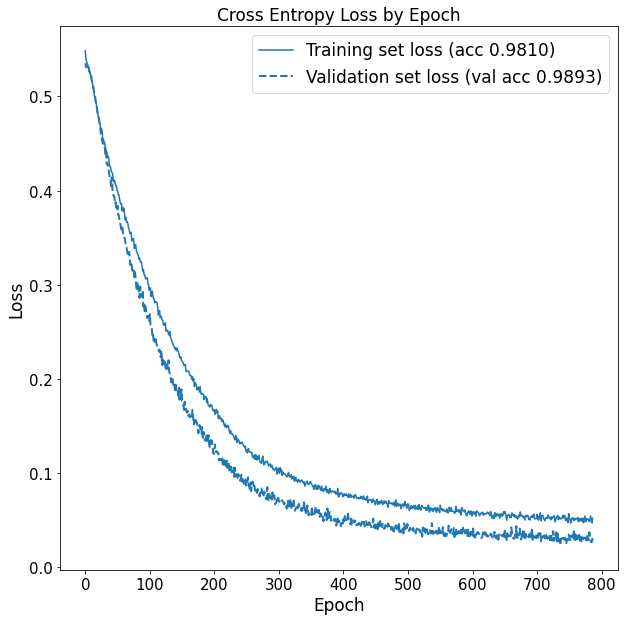

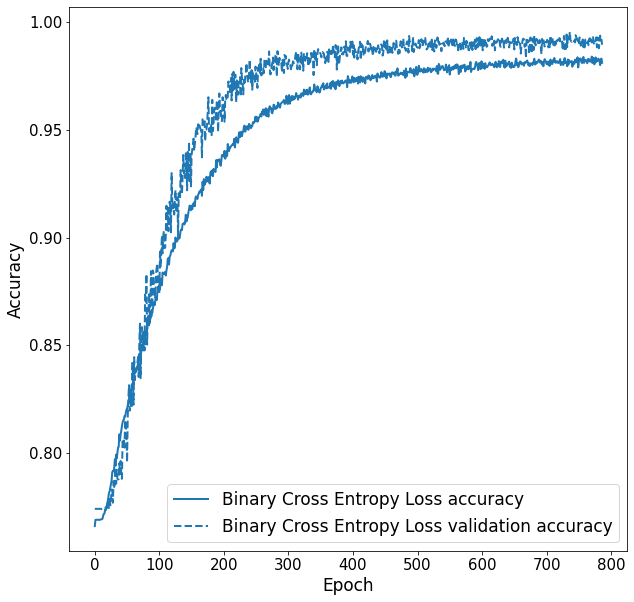

In [71]:
show_losses( [("Binary Cross Entropy Loss", hist)])

In [72]:
from sklearn.metrics import roc_curve
y_pred_train = model.predict(x_train).ravel()
y_pred_test  = model.predict(x_test).ravel()

fpr_keras_train, tpr_keras_train, thresholds_keras = roc_curve(y_train, y_pred_train)
fpr_keras_test , tpr_keras_test , thresholds_keras = roc_curve(y_test , y_pred_test)

In [73]:
from sklearn.metrics import auc
auc_keras_test  = auc(fpr_keras_test, tpr_keras_test)
auc_keras_train = auc(fpr_keras_train, tpr_keras_train)

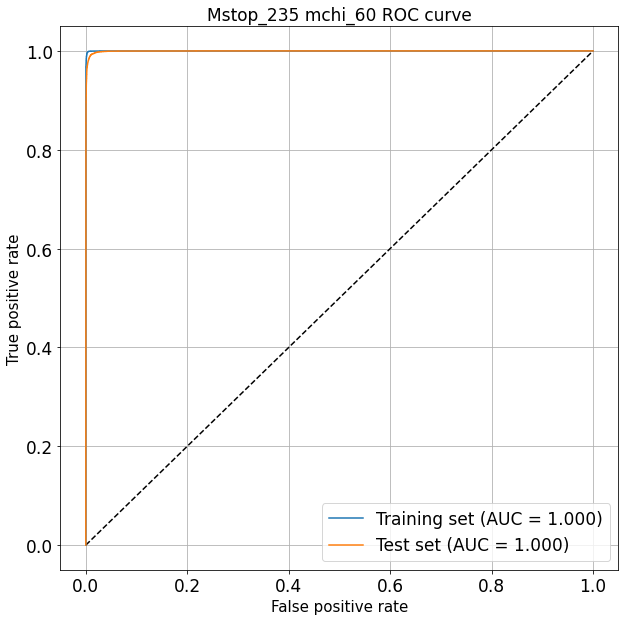

In [56]:
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_train, tpr_keras_train, label='Training set (AUC = {:.3f})'.format(auc_keras_train))
plt.plot(fpr_keras_test , tpr_keras_test , label='Test set (AUC = {:.3f})'.format(auc_keras_test))
plt.tick_params(axis="y", labelsize=17)
plt.tick_params(axis="x", labelsize=17)
plt.xlabel('False positive rate', fontsize=15)
plt.ylabel('True positive rate' , fontsize=15)
plt.title('Mstop_235 mchi_60 ROC curve', fontsize=17)
plt.legend(loc='lower right', fontsize=17)
plt.grid()
#plt.savefig('ROC Mstop 235 Mchi 60.jpg')
plt.show()

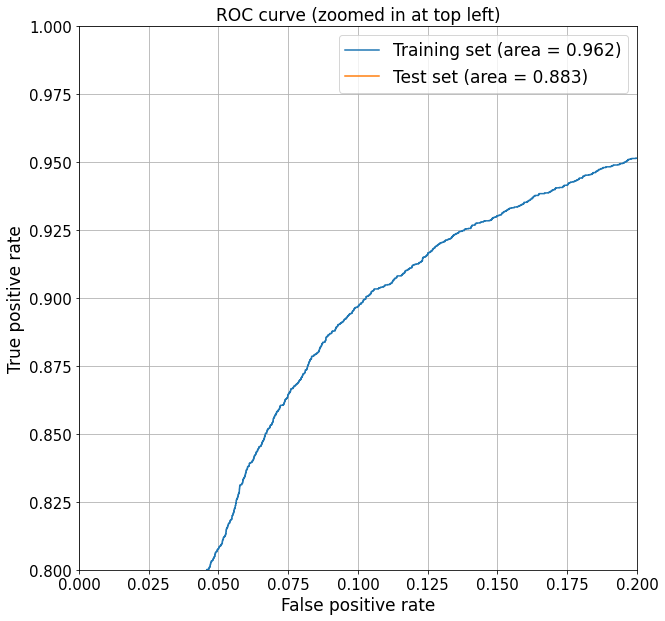

In [37]:
# Zoom in view of the upper left corner.
plt.figure(figsize=(10,10))
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras_train, tpr_keras_train, label='Training set (area = {:.3f})'.format(auc_keras_train))
plt.plot(fpr_keras_test , tpr_keras_test , label='Test set (area = {:.3f})'.format(auc_keras_test))
plt.ylabel('True positive rate' , fontsize=17)
plt.xlabel('False positive rate', fontsize=17)
plt.tick_params(axis="y", labelsize=15)
plt.tick_params(axis="x", labelsize=15)
plt.title('ROC curve (zoomed in at top left)', fontsize=17)
plt.legend(loc='best', fontsize=17)
plt.grid()
plt.show()

In [74]:
tt_pred  = model.predict(tt_df[35000:]) 
st_pred  = model.predict(st_df[10000:]) 
sat_pred = model.predict(sat_df[10000:]) 
vv_pred  = model.predict(vv_df[2000:]) 
si_pred  = model.predict(sig_df[17000:])

2021-04-04 23:14:11.365107: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 253456320 exceeds 10% of free system memory.


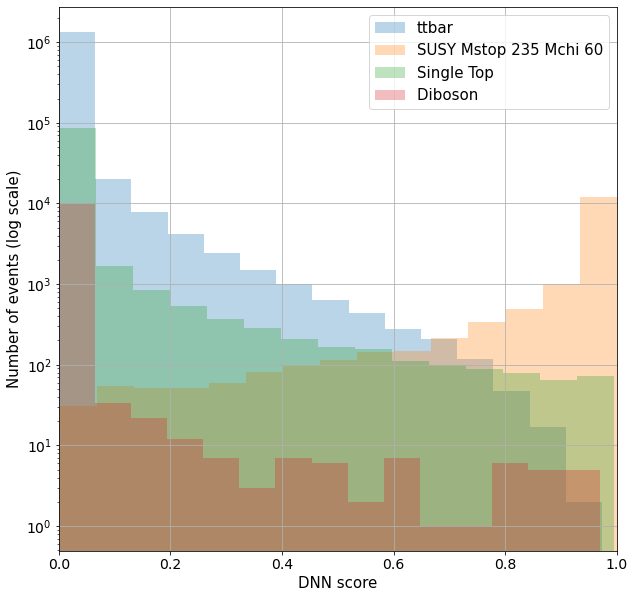

In [76]:
plt.figure(figsize=(10,10))
plt.tick_params(axis="y", labelsize=14)
plt.tick_params(axis="x", labelsize=14)
plt.hist(tt_pred, bins=15, alpha=0.3, label='ttbar')
plt.hist(si_pred, bins=15, alpha=0.3, label='SUSY Mstop 235 Mchi 60')
plt.hist(st_pred, bins=15, alpha=0.3, label='Single Top')
plt.hist(vv_pred, bins=15, alpha=0.3, label='Diboson ')
#plt.hist(sat_pred, bins=15, alpha=0.3, label='Single Antitop')
plt.yscale('log')
plt.xlim(0,1)
plt.xlabel('DNN score', fontsize=15)
plt.ylabel('Number of events (log scale)', fontsize=15)
plt.grid()
plt.legend(loc='best', fontsize=15)
plt.savefig('DNN_score_Mstop_235_Mchi_60.jpg')

In [27]:
np.savetxt('Mstop_235_mchi_60_SUSY_pred.txt', si_pred)
np.savetxt('Mstop_235_mchi_60_tt_pred.txt'  , tt_pred)
np.savetxt('Mstop_235_mchi_60_st_pred.txt'  , st_pred)
np.savetxt('Mstop_235_mchi_60_sat_pred.txt' , sat_pred)
np.savetxt('Mstop_235_mchi_60_vv_pred.txt'  , vv_pred)

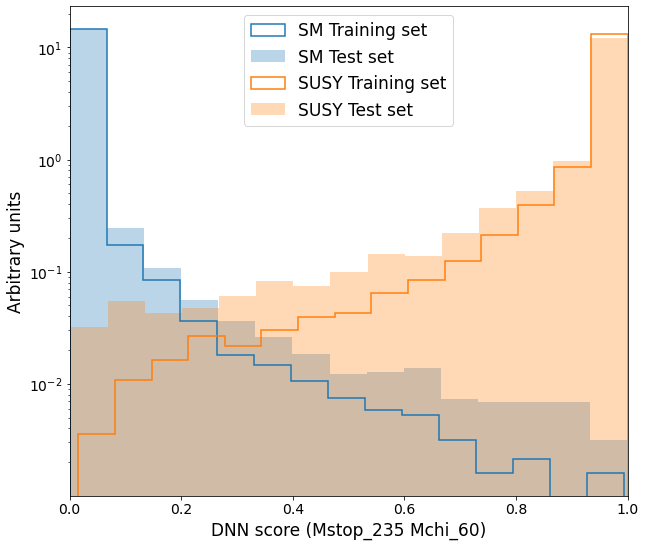

In [75]:
c0 = 'C0'
c1 = 'C1'
plt.figure(figsize=(10,9))
plt.tick_params(axis="y", labelsize=14)
plt.tick_params(axis="x", labelsize=14)
plt.hist(y_pred_train[y_train == 0], bins=15, label='SM Training set', histtype='step', linestyle='solid', linewidth=1.5, density=True, color=c0)
plt.hist(y_pred_test[y_test == 0]  , bins=15, label='SM Test set'    , alpha=0.3, linewidth=1.5, density=True , color=c0)
plt.hist(y_pred_train[y_train == 1], bins=15, label='SUSY Training set', histtype='step' , linestyle='solid', linewidth=1.5, density=True, color=c1)
plt.hist(y_pred_test[y_test == 1]  , bins=15, label='SUSY Test set ', alpha=0.3, linewidth=1.5, density=True, color=c1)

plt.yscale('log')
#plt.ylim(0.1, 30)
plt.xlim(0,1)
plt.xlabel('DNN score (Mstop_235 Mchi_60)', fontsize=17)
plt.ylabel('Arbitrary units', fontsize=17)
plt.legend(loc='upper center', fontsize=17)
#plt.savefig('Train vs test Mstop_235 Mchi_60.jpg')

In [72]:
def CorrMtx(df, dropDuplicates = True):

    # Your dataset is already a correlation matrix.
    # If you have a dateset where you need to include the calculation
    # of a correlation matrix, just uncomment the line below:
    # df = df.corr()
    sns.set(font_scale=1.4)
    # Exclude duplicate correlations by masking uper right values
    if dropDuplicates:    
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

    # Set background color / chart style
    sns.set_style(style = 'white')

    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=(15, 12))

    # Add diverging colormap from red to blue
    #cmap = sns.diverging_palette(250, 10, as_cmap=True)
    #cmap  = sns.color_palette("coolwarm")
    cmap = sns.diverging_palette(0,255,sep=1, as_cmap=True)
                                 
    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        hm = sns.heatmap(df, mask=mask, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax, vmin=-1, vmax=1)
        plt.title('Correlation matrix for input features', fontsize=30)
        plt.savefig('ip_features_corr.png')
    else:
        sns.heatmap(df, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax, vmin=-1, vmax=1)

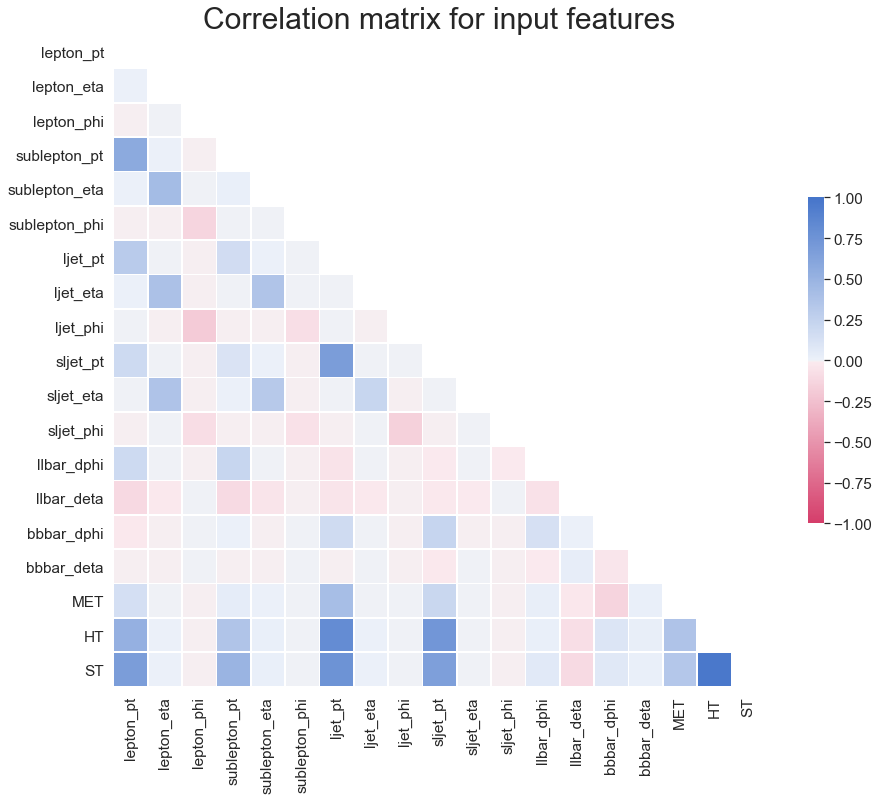

In [73]:
CorrMtx(corr, dropDuplicates = True)